# Time Series Project - Karl Merisalu

Analysing historical bitcoin price data with simple ARIMA (Autoregressive Integrated Moving Average) model and making predictions for future prices

## 1) Importing libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## 2) Loading data

In [102]:
df = pd.read_csv('Kraken_BTCUSD_d.csv', skiprows=1)
df.head(3)

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,2019-06-18,BTCUSD,9335.0,9355.0,9290.0,9319.7,158.46,1.476590e+06
1,2019-06-17,BTCUSD,8976.1,9470.0,8971.9,9335.0,8437.29,7.811025e+07
2,2019-06-16,BTCUSD,8856.8,9390.0,8456.0,8976.1,12551.79,1.140681e+08


## 3) Preparing and cleaning data

In [103]:
df.dtypes

Date           object
Symbol         object
Open          float64
High          float64
Low           float64
Close         float64
Volume BTC    float64
Volume USD    float64
dtype: object

In [104]:
# checking if there are any missing values
df.isnull().values.any()

False

In [105]:
# import datetime in order to start converting data from dataframe to a series
from datetime import datetime

In [106]:
# setting month column to datetime value and setting it as index value
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2019-06-18,BTCUSD,9335.0,9355.0,9290.0,9319.7,158.46,1.476590e+06
2019-06-17,BTCUSD,8976.1,9470.0,8971.9,9335.0,8437.29,7.811025e+07
2019-06-16,BTCUSD,8856.8,9390.0,8456.0,8976.1,12551.79,1.140681e+08
2019-06-15,BTCUSD,8694.0,8912.0,8620.3,8856.8,5294.14,4.639254e+07
2019-06-14,BTCUSD,8237.6,8740.0,8175.0,8694.0,7258.26,6.131792e+07


In [107]:
# assigning Closing price column to a new times series variable
ts_close = df['Close']
type(ts_close)

pandas.core.series.Series

In [108]:
ts_close.describe()

count     2070.000000
mean      2685.903754
std       3437.494834
min        122.000000
25%        409.595000
50%        685.925000
75%       4257.425000
max      19356.900000
Name: Close, dtype: float64

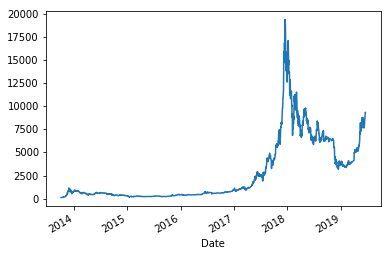

In [109]:
ts_close.plot()

## 4) Decomposition of data
Decomposing data into 3: 
<br>1) trend (The general direction data is travelling (like upwards or downwards) 
<br>2) seasonality (Cycles that we could see repeating in the data) 
<br>3) noise (The random variation that occurs naturally in the data)

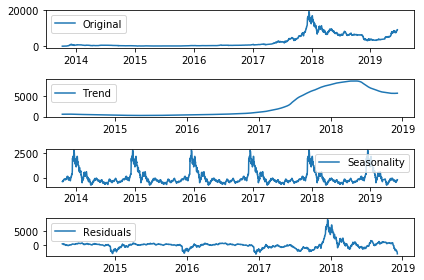

In [134]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_close, freq=365)

# creating 3 new variables of decomposed parts
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_close, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

<b>Note on the above:</b> Clearly, the pre-2017 times, 2017-2018 crypto boom and post boom times are very different in nature and hence difficult to analyse together with the same algorithm. Hence we split the series into more similar periods. As an example we will analyse year 2015 and try to make predictions for 2016.

In [148]:
ts_close_2015 = ts_close[df.index.year == 2015]
ts_close_2015.head()

SyntaxError: invalid syntax (<ipython-input-148-73114a8784d0>, line 1)

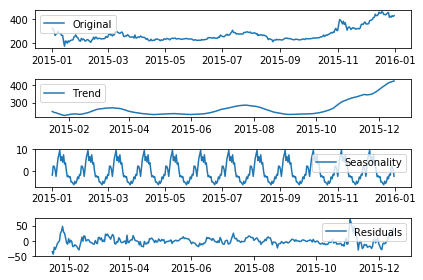

In [144]:
# running the same decomposing method for year 2015 data
decomposition = seasonal_decompose(ts_close_2015, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_close_2015, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

## 5) Model and transform
Making sure that data is stationary - that it's mean, variance and covariance are constant over time

In [145]:
from statsmodels.tsa.stattools import kpss
kpss(ts_close_2015)

C:\Users\Karl\Desktop\datafellowship\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(0.9634364638463488,
 0.01,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In this case, our p-value is less than 0.05 (it is 0.01), meaning we should reject the null hypothesis. This means our data is not stationary.

We need transform our data to make it stationary

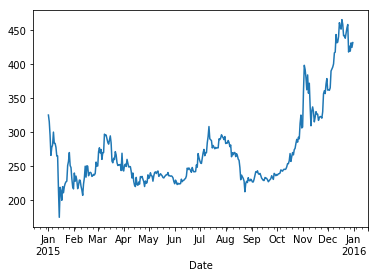

In [192]:
ts_close_2015.plot()

At the moment, our data does not have (1) constant variance or (2) contant mean. A common way to remove this changing variance is to take the natural log of all of the values in our dataset.

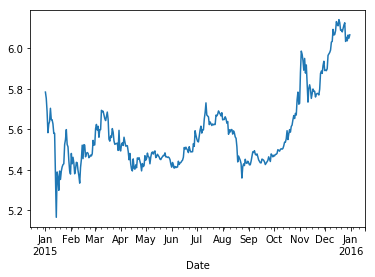

In [150]:
# taking a log of the data to remove exponsential growth (trend) and also increasing variance
ts_close_2015_log = np.log(ts_close_2015)
ts_close_2015_log.plot()

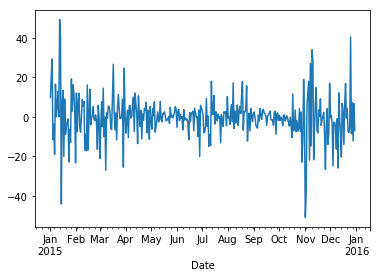

In [193]:
# now with log. differencing the data and plotting. creating a dataset of differences between the values in our dataset
ts_close_2015.diff().plot()

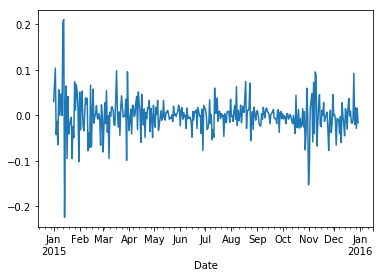

In [194]:
# now with log. differencing the data and plotting. creating a dataset of differences between the values in our dataset
ts_close_2015_log.diff().plot()

In [195]:
# checking for stationarity again. adding drop na because no have 1 less value in dataset due to difference calculation
kpss(ts_close_2015_log.diff().dropna())

(0.33690670721869675,
 0.1,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value is now greater than 0.05 (it's 0.1), so we can accept the null hypothesis that our data is stationary

## 6) ARIMA Model
Autoregressive Integrated Moving Average

In [196]:
# importing relevant libraries for ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [197]:
# This method finds the MSE of a single ARIMA model.
def evaluate_arima_model(data, arima_order):
    split=int(len(data) * 0.8) # Needs to be an integer because it is later used as an index.
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [198]:
# This method evaluates ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [179]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 4)]
d_values = [x for x in range(0, 4)]
q_values = [x for x in range(0, 4)]

In [180]:
# Finally, we find the best ARIMA model for our data (will take a while to execute)
import warnings
warnings.filterwarnings("ignore")
evaluate_models(ts_close_2015, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1534.161
ARIMA(0, 0, 1) MSE=679.251
ARIMA(0, 0, 2) MSE=489.969
ARIMA(0, 0, 3) MSE=382.586
ARIMA(0, 1, 0) MSE=210.423
ARIMA(0, 1, 1) MSE=212.908
ARIMA(0, 1, 2) MSE=214.205
ARIMA(0, 1, 3) MSE=215.984
ARIMA(0, 2, 0) MSE=440.544
ARIMA(0, 2, 1) MSE=210.911
ARIMA(1, 0, 0) MSE=208.359
ARIMA(1, 0, 1) MSE=210.766
ARIMA(1, 0, 2) MSE=212.003
ARIMA(1, 0, 3) MSE=213.566
ARIMA(1, 1, 0) MSE=213.598
ARIMA(1, 2, 0) MSE=337.300
ARIMA(2, 0, 0) MSE=211.394
ARIMA(2, 1, 0) MSE=215.179
ARIMA(2, 1, 1) MSE=215.490
ARIMA(2, 2, 0) MSE=285.505
ARIMA(2, 2, 1) MSE=215.369
ARIMA(3, 0, 0) MSE=212.876
ARIMA(3, 1, 0) MSE=217.496
ARIMA(3, 1, 2) MSE=217.038
ARIMA(3, 2, 0) MSE=281.530
ARIMA(3, 2, 1) MSE=217.750
Best ARIMA(1, 0, 0) MSE=208.359


In [304]:
# selecting "best" variables for the model.
# using results from github workbook, however, the below seems to be more accurate
# p=1
# d=0
# q=0
p=1 # change these to see different chart fits below between predict and actual
d=0 # change these to see different chart fits below between predict and actual
q=0 # change these to see different chart fits below between predict and actual
model = ARIMA(ts_close_2015, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(30)

In [300]:
# summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                  365
Model:                     ARMA(1, 0)   Log Likelihood               -1381.045
Method:                       css-mle   S.D. of innovations             10.585
Date:                Tue, 18 Jun 2019   AIC                           2768.091
Time:                        23:27:57   BIC                           2779.790
Sample:                    12-31-2015   HQIC                          2772.740
                         - 01-01-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         308.0265     45.902      6.710      0.000     218.059     397.994
ar.L1.Close     0.9894      0.008    127.946      0.000       0.974       1.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0107           +0.0000j            1.0107            0.0000
-----------------------------------------------------------------------------
"""

## 7) Plotting the model against original data

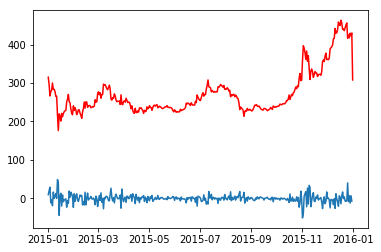

In [301]:
plt.plot(ts_close_2015.diff())
plt.plot(model_fit.predict(), color = 'red') #p, d, q = 1, 0, 0

<b>PROBLEM ABOVE!</b> (TBC) Although works better with p, d, q = 0, 2, 1 and some others (as seen below)

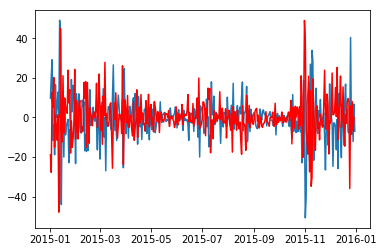

In [305]:
plt.plot(ts_close_2015.diff()) 
plt.plot(model_fit.predict(), color = 'red') # p, d, q = 0, 2, 1

## 8) Forecasting
This section will forecast bitcoin price in the future (30 days into 2016)

In [291]:
periods_to_forecast = 30

In [292]:
# Creating a range of future dates that is the length of the periods I've chosen to forecast
date_range = pd.date_range(ts_close_2015.index[0], periods = periods_to_forecast,
              freq='D').strftime("%Y-%m-%d").tolist()

# Turn that range into a dataframe that includes your predictions
future_dates = pd.DataFrame(date_range, columns = ['Date'])
future_dates['Date'] = pd.to_datetime(future_dates['Date'])
future_dates.set_index('Date', inplace = True)

In [293]:
future_dates['Prediction'] = forecast[0]

In [294]:
future_dates.head()

,Prediction
Date,
2015-12-31,324.141117
2016-01-01,324.984918
2016-01-02,326.652149
2016-01-03,328.120986
2016-01-04,329.542174


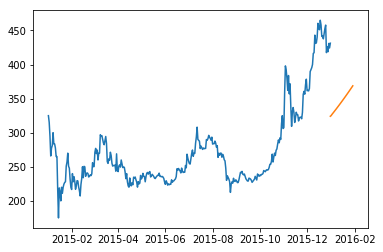

In [295]:
plt.plot(ts_close_2015)
plt.plot(future_dates)
plt.show()

## 9) Evaluation
This forecast could be improved... Help...